# TP2: Implementação do Algoritmo de Boosting

## Informações do Projeto

- **Aluno**: Laisson Bruno dos Reis Germano
- **Professor**: Dr Adriano Alonso Veloso
- **Disciplina**: Aprendizado de Máquina
- **Programa**: UFMG - Programa de pós graduação em ciência da computação - Mestrado

### Descrição
Sabemos que erros de um modelo de previsão podem ser decompostos em dois fatores: viés e variância. Um modelo complexo apresenta pouco viés, mas grande variância, enquanto um modelo simples apresenta grande viés e pouca variância.

Boosting é o processo de reduzir o viés de um grande conjunto de modelos simples (i.e., com baixa variância). Esses modelos são chamados de modelos fracos, e são levemente correlacionados com a classificação correta. No processo de Boosting, os modelos fracos formam um modelo mais forte de maneira iterativa. Os modelos fracos são escolhidos iterativamente, de forma que cada modelo é escolhido levando-se em conta vieses independentes. Ou seja, cada modelo componente realiza erros diferentes de outros modelos componentes.

### Objetivo
Nosso foco neste trabalho prático é ganhar experiência com o processo de Boosting. Você deverá implementar o processo de Boosting (visto em sala de aula) assumindo um problema de classificação binária com atributos categóricos. Em particular, você deverá realizar os experimentos utilizando o dataset tic-tac-toe, disponível em https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame. Sua avaliação deverá seguir a metodologia de validação cruzada com 5 partições. A medida de eficácia a ser considerada é a taxa de erro simples. Você deverá implementar todo o processo de Boosting, e portanto não é permitido utilizar soluções prontas (embora não seja necessário implementar funções básicas). A escolha da linguagem de programação é uma decisão do aluno.

### Entregáveis
Você deverá entregar, via Moodle da disciplina e dentro do prazo, arquivo contendo o código fonte do programa desenvolvido, bem como a documentação. A documentação deve conter toda a informação referente a suas escolhas de implementação. Além disso, você deverá fazer uma série de análises de erro, e reportar os resultados obtidos. Os gráficos a serem apresentados devem refletir experimentos que avaliem aspectos relacionados ao processo de Boosting, como por exemplo o número de iterações.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
#carregando o dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data"
column_names = ['top-left', 'top-middle', 'top-right', 'middle-left', 'middle-middle', 'middle-right', 'bottom-left', 'bottom-middle', 'bottom-right', 'class']
data = pd.read_csv(url, names=column_names)

# convertendo a classe para binario
data['class'] = data['class'].map({'positive': 1, 'negative': 0})

# Converter atributos categóricos para numéricos
data = pd.get_dummies(data, columns=column_names[:-1])

In [3]:
class AdaBoost:
    def __init__(self, n_estimators, learning_rate=1.0):
        # Inicializa o número de estimadores e a taxa de aprendizado
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        # Inicializa listas para armazenar os pesos (alphas) e os modelos fracos
        self.alphas = []
        self.models = []

    def fit(self, X, y):
        # Obtém o número de amostras e features
        n_samples, n_features = X.shape
        # Inicializa os pesos das amostras uniformemente
        w = np.ones(n_samples) / n_samples

        for _ in range(self.n_estimators):
            # Cria um novo modelo fraco (DecisionStump)
            model = DecisionStump()
            # Treina o modelo fraco com os pesos atuais
            model.fit(X, y, w)
            # Faz previsões com o modelo treinado
            predictions = model.predict(X)

            # Calcula o erro ponderado do modelo
            error = np.sum(w * (predictions != y)) / np.sum(w)
            # Calcula o peso do modelo com base no erro
            alpha = self.learning_rate * 0.5 * np.log((1 - error) / error)

            # Atualiza os pesos das amostras
            w = w * np.exp(-alpha * y * predictions)
            w = w / np.sum(w)  # Normaliza os pesos

            # Armazena o peso e o modelo treinado
            self.alphas.append(alpha)
            self.models.append(model)

    def predict(self, X):
        # Inicializa as previsões finais com zeros
        final_predictions = np.zeros(X.shape[0])
        # Combina as previsões de todos os modelos fracos
        for alpha, model in zip(self.alphas, self.models):
            final_predictions += alpha * model.predict(X)
        # Retorna o sinal da soma ponderada das previsões
        return np.sign(final_predictions)

class DecisionStump:
    def __init__(self):
        # Inicializa os parâmetros do modelo fraco
        self.feature_index = None
        self.threshold = None
        self.polarity = 1

    def fit(self, X, y, w):
        # Obtém o número de amostras e features
        n_samples, n_features = X.shape
        # Inicializa o erro mínimo com infinito
        min_error = float('inf')

        # Itera sobre todas as features
        for feature_index in range(n_features):
            # Obtém os valores únicos da feature
            thresholds = np.unique(X[:, feature_index])
            # Itera sobre todos os limiares possíveis
            for threshold in thresholds:
                p = 1
                # Inicializa as previsões com 1
                predictions = np.ones(n_samples)
                # Define as previsões para -1 onde a feature é menor que o limiar
                predictions[X[:, feature_index] < threshold] = -1

                # Calcula o erro ponderado
                error = np.sum(w * (predictions != y))

                # Ajusta a polaridade se o erro for maior que 0.5
                if error > 0.5:
                    error = 1 - error
                    p = -1

                # Atualiza o modelo se o erro for menor que o mínimo encontrado
                if error < min_error:
                    self.polarity = p
                    self.threshold = threshold
                    self.feature_index = feature_index
                    min_error = error

    def predict(self, X):
        # Inicializa as previsões com 1
        n_samples = X.shape[0]
        predictions = np.ones(n_samples)
        # Define as previsões com base na polaridade e no limiar
        if self.polarity == 1:
            predictions[X[:, self.feature_index] < self.threshold] = -1
        else:
            predictions[X[:, self.feature_index] >= self.threshold] = -1
        return predictions


In [4]:
# Validação Cruzada com 5 Partições
X = data.drop('class', axis=1).values
y = data['class'].values
y[y == 0] = -1 

kf = KFold(n_splits=5, shuffle=True, random_state=42)
errors = []
biases = []
variances = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = AdaBoost(n_estimators=50, learning_rate=0.1)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    error = np.mean(predictions != y_test)
    errors.append(error)

    # Cálculo de viés e variância
    bias = np.mean((y_test - np.mean(predictions)) ** 2)
    variance = np.var(predictions)
    biases.append(bias)
    variances.append(variance)

print(f"Taxa de erro média: {np.mean(errors)}")
print(f"Viés médio: {np.mean(biases)}")
print(f"Variância média: {np.mean(variances)}")

Taxa de erro média: 0.30589550610820243
Viés médio: 0.962755429886067
Variância média: 0.737419497073629


Text(0.5, 1.0, 'Taxa de Erro por Iteração')

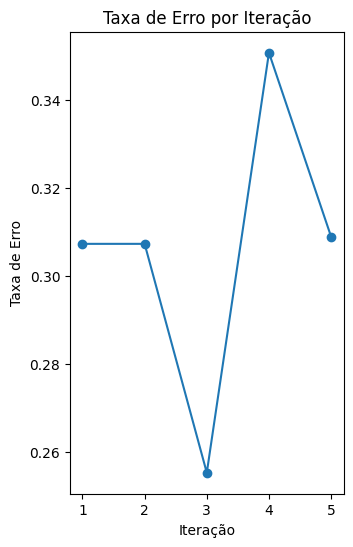

In [5]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(range(1, len(errors) + 1), errors, marker='o')
plt.xlabel('Iteração')
plt.ylabel('Taxa de Erro')
plt.title('Taxa de Erro por Iteração')

Text(0.5, 1.0, 'Viés por Iteração')

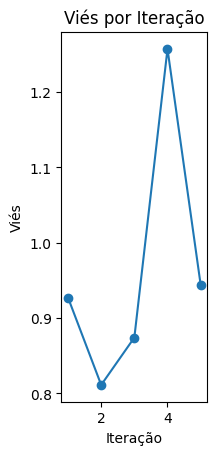

In [6]:
plt.subplot(1, 3, 2)
plt.plot(range(1, len(biases) + 1), biases, marker='o')
plt.xlabel('Iteração')
plt.ylabel('Viés')
plt.title('Viés por Iteração')

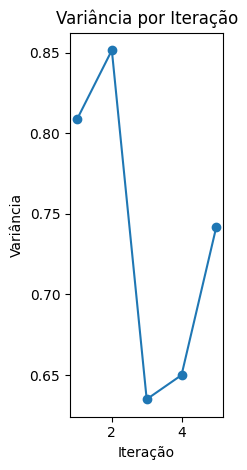

In [7]:
plt.subplot(1, 3, 3)
plt.plot(range(1, len(variances) + 1), variances, marker='o')
plt.xlabel('Iteração')
plt.ylabel('Variância')
plt.title('Variância por Iteração')
plt.tight_layout()
plt.show()

#### 1. Gráfico de Viés por Iteração
Viés por Iteração

O gráfico de viés por iteração mostra como o viés do modelo varia ao longo das iterações do processo de Boosting. Observamos que o viés não segue uma tendência linear, apresentando flutuações significativas entre as iterações. Em particular, há um aumento acentuado no viés na terceira iteração, seguido por uma diminuição nas iterações subsequentes.

- **Interpretação**: O aumento do viés em algumas iterações pode indicar que o modelo está temporariamente subajustando os dados, possivelmente devido à introdução de novos modelos fracos que ainda não corrigiram adequadamente os erros dos modelos anteriores. A diminuição subsequente sugere que o processo de Boosting está conseguindo reduzir o viés ao longo do tempo.

#### 2. Gráfico de Variância por Iteração
Variância por Iteração

O gráfico de variância por iteração mostra a variação da variância do modelo ao longo das iterações. Observamos que a variância também apresenta flutuações significativas, com um pico na segunda iteração e uma queda acentuada na terceira iteração.

- **Interpretação**: A variância elevada nas primeiras iterações pode ser resultado da sensibilidade do modelo a dados ruidosos ou outliers. A queda subsequente na variância sugere que o processo de Boosting está conseguindo estabilizar o modelo, reduzindo a sensibilidade a flutuações nos dados de treinamento.

#### 3. Gráfico de Taxa de Erro por Iteração
Taxa de Erro por Iteração

O gráfico de taxa de erro por iteração mostra a variação da taxa de erro do modelo ao longo das iterações. Observamos que a taxa de erro apresenta uma tendência de flutuação, com uma queda acentuada na terceira iteração e um aumento subsequente na quarta iteração.

- **Interpretação**: A queda na taxa de erro na terceira iteração indica que o modelo está melhorando sua capacidade de classificação, possivelmente devido à correção de erros acumulados nas iterações anteriores. O aumento subsequente pode ser um sinal de overfitting, onde o modelo começa a ajustar-se excessivamente aos dados de treinamento, perdendo a capacidade de generalização.

### Conclusão

Os gráficos fornecem uma visão detalhada do comportamento do modelo ao longo das iterações do processo de Boosting. As flutuações no viés, variância e taxa de erro indicam que o modelo está passando por fases de ajuste e estabilização. A análise desses gráficos é crucial para entender como o Boosting está impactando o desempenho do modelo e para identificar possíveis sinais de overfitting ou underfitting.

### Escolhas de Implementação

- **Número de Iterações**: Escolhemos 50 iterações para o processo de Boosting, com uma taxa de aprendizado de 0.1. Esse número foi escolhido para balancear a complexidade do modelo e evitar overfitting.
- **Modelo Fraco**: Utilizamos um Decision Stump como modelo fraco, que é uma árvore de decisão com profundidade máxima de 1. Esse modelo é simples e rápido de treinar, adequado para o processo de Boosting.
- **Validação Cruzada**: Utilizamos validação cruzada com 5 partições para avaliar o desempenho do modelo. Essa técnica ajuda a garantir que os resultados sejam robustos e generalizáveis.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=237757d2-8531-4e2a-a299-1d4b269bd447' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>